In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown
import seaborn as sns
from time import time, strftime
import datetime
import openpyxl
import seaborn as sns
%matplotlib inline

In [2]:
start_time = time()

In [3]:
#Настройки отображения данных в ноутбуке
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.mode.chained_assignment = None  # default='warn'
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.figsize'] = [10, 10]

In [4]:
def parse_date(s):
    try:
        dt = datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S')
        if dt.year < 1900 or dt.year > 2100 or dt.month < 1 or dt.month > 12 or dt.day < 1 or dt.day > 31 or \
            dt.hour < 0 or dt.hour > 23 or dt.minute < 0 or dt.minute > 59 or dt.second < 0 or dt.second > 59:
            return None
        return dt
    except ValueError:
        return None

In [5]:
RawTransactions = pd.read_csv('../../../fraud-data/2019-08-22.txt', sep=',', 
                   header=None,
                   low_memory=False,
                   skiprows=[0],                   
                   parse_dates=[1],
                   date_parser=parse_date,
                   names=['tranaction_id', 'tx_datetime', 'customer_id', 'terminal_id', 
                          'tx_amount', 'tx_time_seconds', 'tx_time_days', 'tx_fraud', 
                          'tx_fraud_scenario'])

,tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,parsing_error
0,0,2019-08-22 06:51:03,0,711,70.91,24663,0,0,0,
1,1,2019-08-22 05:10:37,0,0,90.55,18637,0,0,0,terminal_id=0;
2,2,2019-08-22 19:05:33,0,753,35.38,68733,0,0,0,
3,3,2019-08-22 07:21:33,0,0,80.41,26493,0,0,0,terminal_id=0;
4,4,2019-08-22 09:06:17,1,981,102.83,32777,0,0,0,
...,...,...,...,...,...,...,...,...,...,...
46988413,46988232,2019-09-20 09:10:40,999996,954,66.92,2538640,29,0,0,
46988414,46988233,2019-09-20 13:52:13,999996,871,30.26,2555533,29,0,0,
46988415,46988234,2019-09-20 15:57:00,999996,594,111.17,2563020,29,0,0,
46988416,46988235,2019-09-20 11:23:45,999998,832,14.02,2546625,29,0,0,


In [ ]:
RawTransactions['parsing_error'] = ''
RawTransactions['parsing_error'][RawTransactions['tx_datetime'].isna()] += "tx_datetime-error; "
duplicates = RawTransactions.duplicated(subset=['tranaction_id'], keep='first')
RawTransactions['parsing_error'][duplicates] += "duplicate tranaction_id; "
RawTransactions['parsing_error'][RawTransactions['tx_amount'] == 0] += "tx_amount=0; "
RawTransactions['parsing_error'][abs(RawTransactions['customer_id']) == 999999] += "customer_id=" + RawTransactions['customer_id'].astype(str) + "; "
RawTransactions['parsing_error'][(RawTransactions['terminal_id'] == 0) | (RawTransactions['terminal_id'] > 10000)] += "terminal_id=" + \
    RawTransactions['terminal_id'].astype(str) + "; "

RawTransactions

In [6]:
RawTransactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46988418 entries, 0 to 46988417
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   tranaction_id      int64         
 1   tx_datetime        datetime64[ns]
 2   customer_id        int64         
 3   terminal_id        int64         
 4   tx_amount          float64       
 5   tx_time_seconds    int64         
 6   tx_time_days       int64         
 7   tx_fraud           int64         
 8   tx_fraud_scenario  int64         
 9   parsing_error      object        
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 3.5+ GB


In [7]:
RawTransactions.describe()

,tranaction_id,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
count,4.698842e+07,4.698842e+07,4.698842e+07,4.698842e+07,4.698842e+07,4.698842e+07,4.698842e+07,4.698842e+07
mean,2.349412e+07,5.004338e+05,2.659723e+04,5.423396e+01,1.296055e+06,1.450063e+01,5.377932e-02,1.084151e-01
std,1.356433e+07,2.885392e+05,1.528138e+06,4.125034e+01,7.480495e+05,8.655416e+00,2.255817e-01,4.568781e-01
min,0.000000e+00,-9.999990e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.174706e+07,2.507560e+05,1.970000e+02,2.195000e+01,6.480142e+05,7.000000e+00,0.000000e+00,0.000000e+00
50%,2.349411e+07,5.008120e+05,5.110000e+02,4.540000e+01,1.296375e+06,1.500000e+01,0.000000e+00,0.000000e+00
75%,3.524117e+07,7.501520e+05,7.970000e+02,7.778000e+01,1.944057e+06,2.200000e+01,0.000000e+00,0.000000e+00
max,4.698824e+07,9.999990e+05,8.951810e+07,3.773340e+03,2.592000e+06,2.900000e+01,1.000000e+00,3.000000e+00


In [8]:
parsing_error = RawTransactions[RawTransactions['parsing_error'] != '']
parsing_error

,tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,parsing_error
1,1,2019-08-22 05:10:37,0,0,90.55,18637,0,0,0,terminal_id=0;
3,3,2019-08-22 07:21:33,0,0,80.41,26493,0,0,0,terminal_id=0;
6,6,2019-08-22 03:12:21,3,0,47.20,11541,0,0,0,terminal_id=0;
12,12,2019-08-22 15:47:54,10,0,58.89,56874,0,0,0,terminal_id=0;
69,69,2019-08-22 12:00:23,44,0,70.64,43223,0,0,0,terminal_id=0;
...,...,...,...,...,...,...,...,...,...,...
46988386,46988205,2019-09-20 14:16:59,999979,0,91.47,2557019,29,0,0,terminal_id=0;
46988400,46988219,2019-09-20 10:04:02,999987,0,52.94,2541842,29,0,0,terminal_id=0;
46988401,46988220,2019-09-20 17:18:10,999987,0,45.04,2567890,29,0,0,terminal_id=0;
46988402,46988221,2019-09-20 17:38:31,999987,0,57.16,2569111,29,0,0,terminal_id=0;


In [ ]:
# parsing_error.to_excel("parsing_error.xlsx", sheet_name="parsing_error", index=False)

In [ ]:
sns.displot(RawTransactions['tx_amount'])

In [ ]:
sns.displot(RawTransactions['customer_id'])

In [10]:
RawTransactions['customer_id'].value_counts()

918024    121
857766    120
330952    119
399172    118
368394    117
         ... 
391720      1
295866      1
603525      1
116160      1
852868      1
Name: customer_id, Length: 988545, dtype: int64

In [ ]:
sns.displot(RawTransactions['terminal_id'])

In [11]:
RawTransactions['terminal_id'].value_counts()

0         2041671
145       1298690
81         774927
97         139794
937         89375
           ...   
21861        1553
22225         333
618230         77
436002          2
22129           1
Name: terminal_id, Length: 1006, dtype: int64

In [ ]:
sns.displot(RawTransactions['tx_fraud'])

In [12]:
RawTransactions['tx_fraud'].value_counts()

0    44461413
1     2527005
Name: tx_fraud, dtype: int64

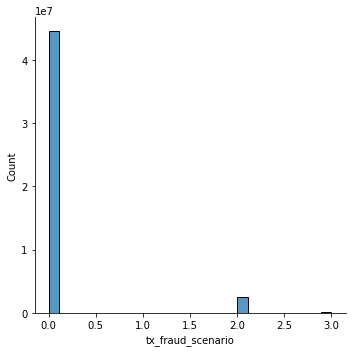

In [13]:
sns.displot(RawTransactions['tx_fraud_scenario'])

In [15]:
RawTransactions['tx_fraud_scenario'].value_counts()

0    44461413
2     2435456
3       65896
1       25653
Name: tx_fraud_scenario, dtype: int64

In [ ]:
sns.displot(RawTransactions['tx_time_seconds'])

In [ ]:
sns.displot(RawTransactions['tx_time_days'])